In [2]:

import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='VkS7DMLeatbGNXLkcNkq438WGucbR4sJYXLsAHnkplSB',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.private.us.cloud-object-storage.appdomain.cloud')

bucket = 'carresalevalueprediction-donotdelete-pr-pe7fdxhshekyux'
object_key = 'autos.csv'

body = cos_client.get_object(Bucket=bucket,Key=object_key)['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df = pd.read_csv(body)
df.head()


,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,2016-03-24 11:52:17,Golf_3_1.6,privat,Angebot,480,test,NaN,1993,manuell,0,golf,150000,0,benzin,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,privat,Angebot,18300,test,coupe,2011,manuell,190,NaN,125000,5,diesel,audi,ja,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",privat,Angebot,9800,test,suv,2004,automatik,163,grand,125000,8,diesel,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,privat,Angebot,1500,test,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,Skoda_Fabia_1.4_TDI_PD_Classic,privat,Angebot,3600,test,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:

import pickle;
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import math

In [4]:
df

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,2016-03-24 11:52:17,Golf_3_1.6,privat,Angebot,480,test,NaN,1993,manuell,0,golf,150000,0,benzin,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,privat,Angebot,18300,test,coupe,2011,manuell,190,NaN,125000,5,diesel,audi,ja,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",privat,Angebot,9800,test,suv,2004,automatik,163,grand,125000,8,diesel,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,privat,Angebot,1500,test,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,Skoda_Fabia_1.4_TDI_PD_Classic,privat,Angebot,3600,test,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371523,2016-03-14 17:48:27,Suche_t4___vito_ab_6_sitze,privat,Angebot,2200,test,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
371524,2016-03-05 19:56:21,Smart_smart_leistungssteigerung_100ps,privat,Angebot,1199,test,cabrio,2000,automatik,101,fortwo,125000,3,benzin,smart,nein,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
371525,2016-03-19 18:57:12,Volkswagen_Multivan_T4_TDI_7DC_UY2,privat,Angebot,9200,test,bus,1996,manuell,102,transporter,150000,3,diesel,volkswagen,nein,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26
371526,2016-03-20 19:41:08,VW_Golf_Kombi_1_9l_TDI,privat,Angebot,3400,test,kombi,2002,manuell,100,golf,150000,6,diesel,volkswagen,NaN,2016-03-20 00:00:00,0,40764,2016-03-24 12:45:21


In [5]:
df.abtest.unique()

array(['test', 'control'], dtype=object)

In [6]:
df.lastSeen.unique()

array(['2016-04-07 03:16:57', '2016-04-07 01:46:50',
       '2016-04-05 12:47:46', ..., '2016-03-19 20:44:43',
       '2016-03-29 10:17:23', '2016-03-21 10:42:49'], dtype=object)

In [7]:
deleteList=["nrOfPictures","lastSeen","offerType","seller","dateCrawled","dateCreated"]
df.drop(deleteList,axis=1,inplace=True)

In [8]:
hpUnique=df.powerPS.unique();

In [9]:
hpUnique.sort()

In [10]:
hpUnique

array([    0,     1,     2,     3,     4,     5,     6,     7,     8,
           9,    10,    11,    12,    13,    14,    15,    16,    17,
          18,    19,    20,    21,    22,    23,    24,    25,    26,
          27,    28,    29,    30,    31,    32,    33,    34,    35,
          36,    37,    38,    39,    40,    41,    42,    43,    44,
          45,    46,    47,    48,    49,    50,    51,    52,    53,
          54,    55,    56,    57,    58,    59,    60,    61,    62,
          63,    64,    65,    66,    67,    68,    69,    70,    71,
          72,    73,    74,    75,    76,    77,    78,    79,    80,
          81,    82,    83,    84,    85,    86,    87,    88,    89,
          90,    91,    92,    93,    94,    95,    96,    97,    98,
          99,   100,   101,   102,   103,   104,   105,   106,   107,
         108,   109,   110,   111,   112,   113,   114,   115,   116,
         117,   118,   119,   120,   121,   122,   123,   124,   125,
         126,   127,

In [11]:
df = df[(df.powerPS > 60) & (df.powerPS < 500)]
df.shape

(290183, 14)

In [12]:
df.isnull().sum()

name                       0
price                      0
abtest                     0
vehicleType            18903
yearOfRegistration         0
gearbox                 4989
powerPS                    0
model                  11640
kilometer                  0
monthOfRegistration        0
fuelType               17375
brand                      0
notRepairedDamage      41447
postalCode                 0
dtype: int64

In [13]:
df["yearOfRegistration"].max()

9999

In [14]:
df = df[(df.yearOfRegistration > 1980) & (df.yearOfRegistration < 2019)]
df.shape

(288112, 14)

In [15]:
df


,name,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,postalCode
1,A5_Sportback_2.7_Tdi,18300,test,coupe,2011,manuell,190,NaN,125000,5,diesel,audi,ja,66954
2,"Jeep_Grand_Cherokee_""Overland""",9800,test,suv,2004,automatik,163,grand,125000,8,diesel,jeep,NaN,90480
3,GOLF_4_1_4__3TÜRER,1500,test,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein,91074
4,Skoda_Fabia_1.4_TDI_PD_Classic,3600,test,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein,60437
5,BMW_316i___e36_Limousine___Bastlerfahrzeug__Ex...,650,test,limousine,1995,manuell,102,3er,150000,10,benzin,bmw,ja,33775
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371520,turbo_defekt,3200,control,limousine,2004,manuell,225,leon,150000,5,benzin,seat,ja,96465
371524,Smart_smart_leistungssteigerung_100ps,1199,test,cabrio,2000,automatik,101,fortwo,125000,3,benzin,smart,nein,26135
371525,Volkswagen_Multivan_T4_TDI_7DC_UY2,9200,test,bus,1996,manuell,102,transporter,150000,3,diesel,volkswagen,nein,87439
371526,VW_Golf_Kombi_1_9l_TDI,3400,test,kombi,2002,manuell,100,golf,150000,6,diesel,volkswagen,NaN,40764


In [16]:
priceRange=df.price.unique()
priceRange.sort()
priceRange.mean()

82550.00327300731

In [17]:
df = df[(df.price > 200) & (df.price < 75000)]
df.shape

(279209, 14)

In [18]:
df.monthOfRegistration.unique()

array([ 5,  8,  6,  7, 10,  0, 12, 11,  2,  3,  1,  4,  9])

In [19]:
df = df[(df.monthOfRegistration >= 1) & (df.monthOfRegistration <= 12)]
df.shape

(263758, 14)

In [20]:
df.notRepairedDamage.isnull().sum()

30335

In [21]:
# sdf=df.copy()
# ldf=sdf.drop_duplicates(['price', 'abtest', 'vehicleType', 'yearOfRegistration', 'gearbox',
#        'powerPS','kilometer', 'monthOfRegistration', 'fuelType',
#        'brand', 'notRepairedDamage','model','postalCode'])
# ldf.shape

In [22]:
# sdf.dropna(how="any",inplace=True)
# sdf.shape

In [23]:
df.model.unique()
modelList=['golf', 'grand', 'fabia', '3er', '2_reihe', 'c_max', '3_reihe',
       'passat', 'navara', 'twingo', 'a_klasse', 'scirocco', '5er',
       'meriva', 'andere', 'c4', 'civic', 'e_klasse', 'one', 'fortwo',
       'clio', '1er', 'b_klasse', 'punto', 'a8', 'jetta', 'astra',
       'c_klasse', 'micra', 'vito', 'sprinter', 'escort', 'forester',
       'xc_reihe', 'fiesta', 'scenic', 'a1', 'transporter', 'focus', 'a4',
       'tt', 'a6', 'jazz', 'omega', 'polo', 'slk', '7er', 'combo', '80',
       '147', 'glk', 'z_reihe', 'sportage', 'sorento', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'insignia', 'almera', 'megane', 'a3',
       'r19', 'mondeo', 'cordoba', 'colt', 'vectra', 'lupo', 'berlingo',
       'm_klasse', 'tiguan', '6_reihe', 'up', 'i_reihe', 'ceed', 'kangoo',
       '5_reihe', 'yeti', 'octavia', 'zafira', 'mii', 'rx_reihe', 'corsa',
       '6er', 'panda', 'beetle', 'rio', 'touareg', 'logan', 'caddy',
       'spider', 's_max', 'modus', 'a2', 'x_reihe', 'a5', 'galaxy', 'c3',
       'viano', 's_klasse', '1_reihe', 'sharan', 'avensis', 'sl',
       'roomster', 'q5', 'santa', 'leon', 'cooper', '4_reihe',
       'ptcruiser', 'clk', 'primera', 'espace', 'exeo', '159', 'transit',
       'juke', 'ka', 'v40', 'carisma', 'accord', 'corolla', 'phaeton',
       'boxster', 'verso', 'rav', 'kuga', 'qashqai', 'swift', 'picanto',
       'superb', 'stilo', 'alhambra', 'm_reihe', 'roadster', 'ypsilon',
       'galant', 'justy', 'impreza', '90', 'sirion', 'signum',
       'crossfire', 'duster', 'v50', 'mx_reihe', 'discovery', 'c_reihe',
       'v_klasse', 'yaris', 'c5', 'aygo', 'cc', 'carnival', 'fusion',
       'bora', 'agila', '911', 'cl', 'tigra', '156', '300c', '500', '100',
       'q3', 'cr_reihe', 'spark', 'x_type', 'ducato', 's_type', 'x_trail',
       'toledo', 'altea', 'voyager', 'matiz', 'v70', 'bravo',
       'range_rover', 'tucson', 'fox', 'q7', 'c1', 'kadett', 'jimny',
       'cx_reihe', 'cayenne', 'wrangler', 'lybra', 'range_rover_sport',
       'lancer', 'freelander', 'captiva', 'laguna', 'c2',
       'range_rover_evoque', 'sandero', 'note', 'antara', '900',
       'defender', 'clubman', 'forfour', 'legacy', 'pajero', 'auris',
       'niva', 's60', 'nubira', 'vivaro', 'g_klasse', 'cherokee', 'lodgy',
       'lanos', '850', 'calibra', 'serie_2', 'charade', 'croma', 'cuore',
       'citigo', 'outlander', 'gl', 'doblo', 'musa', 'amarok', 'arosa',
       '9000', 'kalos', 'v60', 'aveo', '200', '145', 'b_max', 'delta',
       'rangerover', 'materia', 'terios', 'move', 'kalina', 'i3',
       'kaefer', 'kappa', 'samara', 'discovery_sport', 'seicento']

for models in modelList:
    df.model.replace(to_replace=models,value=int(modelList.index(models)) ,inplace=True)

In [24]:
df.notRepairedDamage.replace(to_replace="ja",value="1",inplace=True)

In [25]:
df.notRepairedDamage.replace(to_replace="nein",value="0",inplace=True)

In [26]:
df.notRepairedDamage.replace(to_replace="NaN",value="2",inplace=True)

In [27]:
fuelType=['diesel', 'benzin','lpg', 'andere', 'hybrid', 'cng',
       'elektro']

In [28]:
for fuel in fuelType:
    df.fuelType.replace(to_replace=fuel,value=int(fuelType.index(fuel)),inplace=True)


In [29]:
df

,name,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,postalCode
1,A5_Sportback_2.7_Tdi,18300,test,coupe,2011,manuell,190,NaN,125000,5,0.0,audi,1,66954
2,"Jeep_Grand_Cherokee_""Overland""",9800,test,suv,2004,automatik,163,1.0,125000,8,0.0,jeep,NaN,90480
3,GOLF_4_1_4__3TÜRER,1500,test,kleinwagen,2001,manuell,75,0.0,150000,6,1.0,volkswagen,0,91074
4,Skoda_Fabia_1.4_TDI_PD_Classic,3600,test,kleinwagen,2008,manuell,69,2.0,90000,7,0.0,skoda,0,60437
5,BMW_316i___e36_Limousine___Bastlerfahrzeug__Ex...,650,test,limousine,1995,manuell,102,3.0,150000,10,1.0,bmw,1,33775
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371520,turbo_defekt,3200,control,limousine,2004,manuell,225,108.0,150000,5,1.0,seat,1,96465
371524,Smart_smart_leistungssteigerung_100ps,1199,test,cabrio,2000,automatik,101,19.0,125000,3,1.0,smart,0,26135
371525,Volkswagen_Multivan_T4_TDI_7DC_UY2,9200,test,bus,1996,manuell,102,37.0,150000,3,0.0,volkswagen,0,87439
371526,VW_Golf_Kombi_1_9l_TDI,3400,test,kombi,2002,manuell,100,0.0,150000,6,0.0,volkswagen,NaN,40764


In [30]:
df

,name,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,postalCode
1,A5_Sportback_2.7_Tdi,18300,test,coupe,2011,manuell,190,NaN,125000,5,0.0,audi,1,66954
2,"Jeep_Grand_Cherokee_""Overland""",9800,test,suv,2004,automatik,163,1.0,125000,8,0.0,jeep,NaN,90480
3,GOLF_4_1_4__3TÜRER,1500,test,kleinwagen,2001,manuell,75,0.0,150000,6,1.0,volkswagen,0,91074
4,Skoda_Fabia_1.4_TDI_PD_Classic,3600,test,kleinwagen,2008,manuell,69,2.0,90000,7,0.0,skoda,0,60437
5,BMW_316i___e36_Limousine___Bastlerfahrzeug__Ex...,650,test,limousine,1995,manuell,102,3.0,150000,10,1.0,bmw,1,33775
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371520,turbo_defekt,3200,control,limousine,2004,manuell,225,108.0,150000,5,1.0,seat,1,96465
371524,Smart_smart_leistungssteigerung_100ps,1199,test,cabrio,2000,automatik,101,19.0,125000,3,1.0,smart,0,26135
371525,Volkswagen_Multivan_T4_TDI_7DC_UY2,9200,test,bus,1996,manuell,102,37.0,150000,3,0.0,volkswagen,0,87439
371526,VW_Golf_Kombi_1_9l_TDI,3400,test,kombi,2002,manuell,100,0.0,150000,6,0.0,volkswagen,NaN,40764


In [31]:
gearBoxType=['manuell','automatik']
for gear in gearBoxType:
    df.gearbox.replace(to_replace=gear,value=int(gearBoxType.index(gear)) ,inplace=True)


In [32]:
df

,name,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,postalCode
1,A5_Sportback_2.7_Tdi,18300,test,coupe,2011,0.0,190,NaN,125000,5,0.0,audi,1,66954
2,"Jeep_Grand_Cherokee_""Overland""",9800,test,suv,2004,1.0,163,1.0,125000,8,0.0,jeep,NaN,90480
3,GOLF_4_1_4__3TÜRER,1500,test,kleinwagen,2001,0.0,75,0.0,150000,6,1.0,volkswagen,0,91074
4,Skoda_Fabia_1.4_TDI_PD_Classic,3600,test,kleinwagen,2008,0.0,69,2.0,90000,7,0.0,skoda,0,60437
5,BMW_316i___e36_Limousine___Bastlerfahrzeug__Ex...,650,test,limousine,1995,0.0,102,3.0,150000,10,1.0,bmw,1,33775
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371520,turbo_defekt,3200,control,limousine,2004,0.0,225,108.0,150000,5,1.0,seat,1,96465
371524,Smart_smart_leistungssteigerung_100ps,1199,test,cabrio,2000,1.0,101,19.0,125000,3,1.0,smart,0,26135
371525,Volkswagen_Multivan_T4_TDI_7DC_UY2,9200,test,bus,1996,0.0,102,37.0,150000,3,0.0,volkswagen,0,87439
371526,VW_Golf_Kombi_1_9l_TDI,3400,test,kombi,2002,0.0,100,0.0,150000,6,0.0,volkswagen,NaN,40764


In [33]:
vehicleTypeList=['coupe', 'suv', 'kleinwagen', 'limousine', 'cabrio', 'bus', 'kombi','andere']

In [34]:
for veh in vehicleTypeList:
    df.vehicleType.replace(to_replace=veh,value=int(vehicleTypeList.index(veh)) ,inplace=True)


In [35]:
df

,name,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,postalCode
1,A5_Sportback_2.7_Tdi,18300,test,0.0,2011,0.0,190,NaN,125000,5,0.0,audi,1,66954
2,"Jeep_Grand_Cherokee_""Overland""",9800,test,1.0,2004,1.0,163,1.0,125000,8,0.0,jeep,NaN,90480
3,GOLF_4_1_4__3TÜRER,1500,test,2.0,2001,0.0,75,0.0,150000,6,1.0,volkswagen,0,91074
4,Skoda_Fabia_1.4_TDI_PD_Classic,3600,test,2.0,2008,0.0,69,2.0,90000,7,0.0,skoda,0,60437
5,BMW_316i___e36_Limousine___Bastlerfahrzeug__Ex...,650,test,3.0,1995,0.0,102,3.0,150000,10,1.0,bmw,1,33775
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371520,turbo_defekt,3200,control,3.0,2004,0.0,225,108.0,150000,5,1.0,seat,1,96465
371524,Smart_smart_leistungssteigerung_100ps,1199,test,4.0,2000,1.0,101,19.0,125000,3,1.0,smart,0,26135
371525,Volkswagen_Multivan_T4_TDI_7DC_UY2,9200,test,5.0,1996,0.0,102,37.0,150000,3,0.0,volkswagen,0,87439
371526,VW_Golf_Kombi_1_9l_TDI,3400,test,6.0,2002,0.0,100,0.0,150000,6,0.0,volkswagen,NaN,40764


In [36]:
abTestList=['test', 'control']

In [37]:
for ab in abTestList:
    df.abtest.replace(to_replace=ab,value=int(abTestList.index(ab)) ,inplace=True)


In [38]:

df

,name,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,postalCode
1,A5_Sportback_2.7_Tdi,18300,0,0.0,2011,0.0,190,NaN,125000,5,0.0,audi,1,66954
2,"Jeep_Grand_Cherokee_""Overland""",9800,0,1.0,2004,1.0,163,1.0,125000,8,0.0,jeep,NaN,90480
3,GOLF_4_1_4__3TÜRER,1500,0,2.0,2001,0.0,75,0.0,150000,6,1.0,volkswagen,0,91074
4,Skoda_Fabia_1.4_TDI_PD_Classic,3600,0,2.0,2008,0.0,69,2.0,90000,7,0.0,skoda,0,60437
5,BMW_316i___e36_Limousine___Bastlerfahrzeug__Ex...,650,0,3.0,1995,0.0,102,3.0,150000,10,1.0,bmw,1,33775
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371520,turbo_defekt,3200,1,3.0,2004,0.0,225,108.0,150000,5,1.0,seat,1,96465
371524,Smart_smart_leistungssteigerung_100ps,1199,0,4.0,2000,1.0,101,19.0,125000,3,1.0,smart,0,26135
371525,Volkswagen_Multivan_T4_TDI_7DC_UY2,9200,0,5.0,1996,0.0,102,37.0,150000,3,0.0,volkswagen,0,87439
371526,VW_Golf_Kombi_1_9l_TDI,3400,0,6.0,2002,0.0,100,0.0,150000,6,0.0,volkswagen,NaN,40764


In [39]:
df.name.unique()

array(['A5_Sportback_2.7_Tdi', 'Jeep_Grand_Cherokee_"Overland"',
       'GOLF_4_1_4__3TÜRER', ..., 'Smart_smart_leistungssteigerung_100ps',
       'VW_Golf_Kombi_1_9l_TDI',
       'BMW_M135i_vollausgestattet_NP_52.720____Euro'], dtype=object)

In [40]:
df.drop(['name'],axis=1,inplace=True)

In [41]:
df

,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,postalCode
1,18300,0,0.0,2011,0.0,190,NaN,125000,5,0.0,audi,1,66954
2,9800,0,1.0,2004,1.0,163,1.0,125000,8,0.0,jeep,NaN,90480
3,1500,0,2.0,2001,0.0,75,0.0,150000,6,1.0,volkswagen,0,91074
4,3600,0,2.0,2008,0.0,69,2.0,90000,7,0.0,skoda,0,60437
5,650,0,3.0,1995,0.0,102,3.0,150000,10,1.0,bmw,1,33775
...,...,...,...,...,...,...,...,...,...,...,...,...,...
371520,3200,1,3.0,2004,0.0,225,108.0,150000,5,1.0,seat,1,96465
371524,1199,0,4.0,2000,1.0,101,19.0,125000,3,1.0,smart,0,26135
371525,9200,0,5.0,1996,0.0,102,37.0,150000,3,0.0,volkswagen,0,87439
371526,3400,0,6.0,2002,0.0,100,0.0,150000,6,0.0,volkswagen,NaN,40764


In [42]:
df.brand.unique()

array(['audi', 'jeep', 'volkswagen', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'citroen',
       'honda', 'mini', 'smart', 'fiat', 'seat', 'subaru', 'volvo',
       'mitsubishi', 'hyundai', 'alfa_romeo', 'kia', 'lancia', 'porsche',
       'toyota', 'dacia', 'suzuki', 'chrysler', 'sonstige_autos',
       'jaguar', 'rover', 'saab', 'chevrolet', 'daihatsu', 'land_rover',
       'lada', 'daewoo'], dtype=object)

In [43]:
brandlist=['audi', 'jeep', 'volkswagen', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'citroen',
       'honda', 'mini', 'smart', 'fiat', 'seat', 'subaru', 'volvo',
       'mitsubishi', 'hyundai', 'alfa_romeo', 'kia', 'lancia', 'porsche',
       'toyota', 'dacia', 'suzuki', 'chrysler', 'sonstige_autos',
       'jaguar', 'rover', 'saab', 'chevrolet', 'daihatsu', 'land_rover',
       'lada', 'daewoo']
for brand in brandlist:
    df.brand.replace(to_replace=brand,value=int(brandlist.index(brand)) ,inplace=True)


In [44]:
df

,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,postalCode
1,18300,0,0.0,2011,0.0,190,NaN,125000,5,0.0,0,1,66954
2,9800,0,1.0,2004,1.0,163,1.0,125000,8,0.0,1,NaN,90480
3,1500,0,2.0,2001,0.0,75,0.0,150000,6,1.0,2,0,91074
4,3600,0,2.0,2008,0.0,69,2.0,90000,7,0.0,3,0,60437
5,650,0,3.0,1995,0.0,102,3.0,150000,10,1.0,4,1,33775
...,...,...,...,...,...,...,...,...,...,...,...,...,...
371520,3200,1,3.0,2004,0.0,225,108.0,150000,5,1.0,17,1,96465
371524,1199,0,4.0,2000,1.0,101,19.0,125000,3,1.0,15,0,26135
371525,9200,0,5.0,1996,0.0,102,37.0,150000,3,0.0,2,0,87439
371526,3400,0,6.0,2002,0.0,100,0.0,150000,6,0.0,2,NaN,40764


In [45]:
df.isnull().sum()

price                      0
abtest                     0
vehicleType            12954
yearOfRegistration         0
gearbox                 3101
powerPS                    0
model                   8193
kilometer                  0
monthOfRegistration        0
fuelType               11728
brand                      0
notRepairedDamage      30335
postalCode                 0
dtype: int64

In [46]:

for column in df.columns:
    df[column].fillna(df[column].mode()[0], inplace=True)

In [47]:
df.isnull().sum()

price                  0
abtest                 0
vehicleType            0
yearOfRegistration     0
gearbox                0
powerPS                0
model                  0
kilometer              0
monthOfRegistration    0
fuelType               0
brand                  0
notRepairedDamage      0
postalCode             0
dtype: int64

In [48]:
sdf=df.copy()
# ldf=sdf.drop_duplicates(['price', 'abtest', 'vehicleType', 'yearOfRegistration', 'gearbox',
#        'powerPS', 'kilometer', 'monthOfRegistration', 'fuelType',
#        'brand', 'notRepairedDamage','model','postalCode'])
ldf=df.copy()
ldf.shape

(263758, 13)

In [49]:
print(sdf)

        price  abtest  vehicleType  yearOfRegistration  gearbox  powerPS  \
1       18300       0          0.0                2011      0.0      190   
2        9800       0          1.0                2004      1.0      163   
3        1500       0          2.0                2001      0.0       75   
4        3600       0          2.0                2008      0.0       69   
5         650       0          3.0                1995      0.0      102   
...       ...     ...          ...                 ...      ...      ...   
371520   3200       1          3.0                2004      0.0      225   
371524   1199       0          4.0                2000      1.0      101   
371525   9200       0          5.0                1996      0.0      102   
371526   3400       0          6.0                2002      0.0      100   
371527  28990       1          3.0                2013      0.0      320   

        model  kilometer  monthOfRegistration  fuelType  brand  \
1         0.0     125

In [50]:
ldf['vehicleType'] = ldf['vehicleType'].astype(int)
ldf['gearbox'] = ldf['gearbox'].astype(int)
ldf['model'] = ldf['model'].astype(int)
ldf['fuelType'] = ldf['fuelType'].astype(int)
ldf['notRepairedDamage'] = ldf['notRepairedDamage'].astype(int)

In [51]:
display(ldf.dtypes)

price                  int64
abtest                 int64
vehicleType            int64
yearOfRegistration     int64
gearbox                int64
powerPS                int64
model                  int64
kilometer              int64
monthOfRegistration    int64
fuelType               int64
brand                  int64
notRepairedDamage      int64
postalCode             int64
dtype: object

In [52]:
ydf=ldf.drop(['abtest', 'vehicleType', 'yearOfRegistration', 'gearbox',
       'powerPS', 'kilometer', 'monthOfRegistration', 'fuelType',
       'brand', 'notRepairedDamage','model','postalCode'],axis=1,inplace=False)


xdf=ldf.drop(['price'],axis=1,inplace=False)

In [53]:
xdf

,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,postalCode
1,0,0,2011,0,190,0,125000,5,0,0,1,66954
2,0,1,2004,1,163,1,125000,8,0,1,0,90480
3,0,2,2001,0,75,0,150000,6,1,2,0,91074
4,0,2,2008,0,69,2,90000,7,0,3,0,60437
5,0,3,1995,0,102,3,150000,10,1,4,1,33775
...,...,...,...,...,...,...,...,...,...,...,...,...
371520,1,3,2004,0,225,108,150000,5,1,17,1,96465
371524,0,4,2000,1,101,19,125000,3,1,15,0,26135
371525,0,5,1996,0,102,37,150000,3,0,2,0,87439
371526,0,6,2002,0,100,0,150000,6,0,2,0,40764


In [54]:
ydf

,price
1,18300
2,9800
3,1500
4,3600
5,650
...,...
371520,3200
371524,1199
371525,9200
371526,3400


In [55]:
sc=MinMaxScaler(feature_range=(0,1))
# new_x = sc.fit_transform(xdf)

# new_y=sc.fit_transform(ydf)
new_x = xdf
new_y=ydf

In [56]:
X_train,X_test,Y_train,Y_test = train_test_split(xdf, ydf, train_size=0.7,random_state=4)
regressor = RandomForestRegressor(n_estimators = 100, min_samples_leaf=2)     

In [57]:
X_train.shape,Y_train.shape

((184630, 12), (184630, 1))

In [58]:
regressor.fit(X_train,np.ravel(Y_train,order='C'))

RandomForestRegressor(min_samples_leaf=2)

In [59]:
regressor.predict(X_test)

array([ 4283.94072944,  1205.96964286,  2763.51072222, ...,
        2770.62677778, 23201.71224603,  3485.01580159])

In [60]:
test = [[0,1.0,2004,1.0,163,1.0,125000,8,0.0,1,0,90480]]
regressor.predict(test)[0]

/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


9441.919095238096

In [61]:
regressor.score(X_test,Y_test)

0.8999021761206891

## Graph

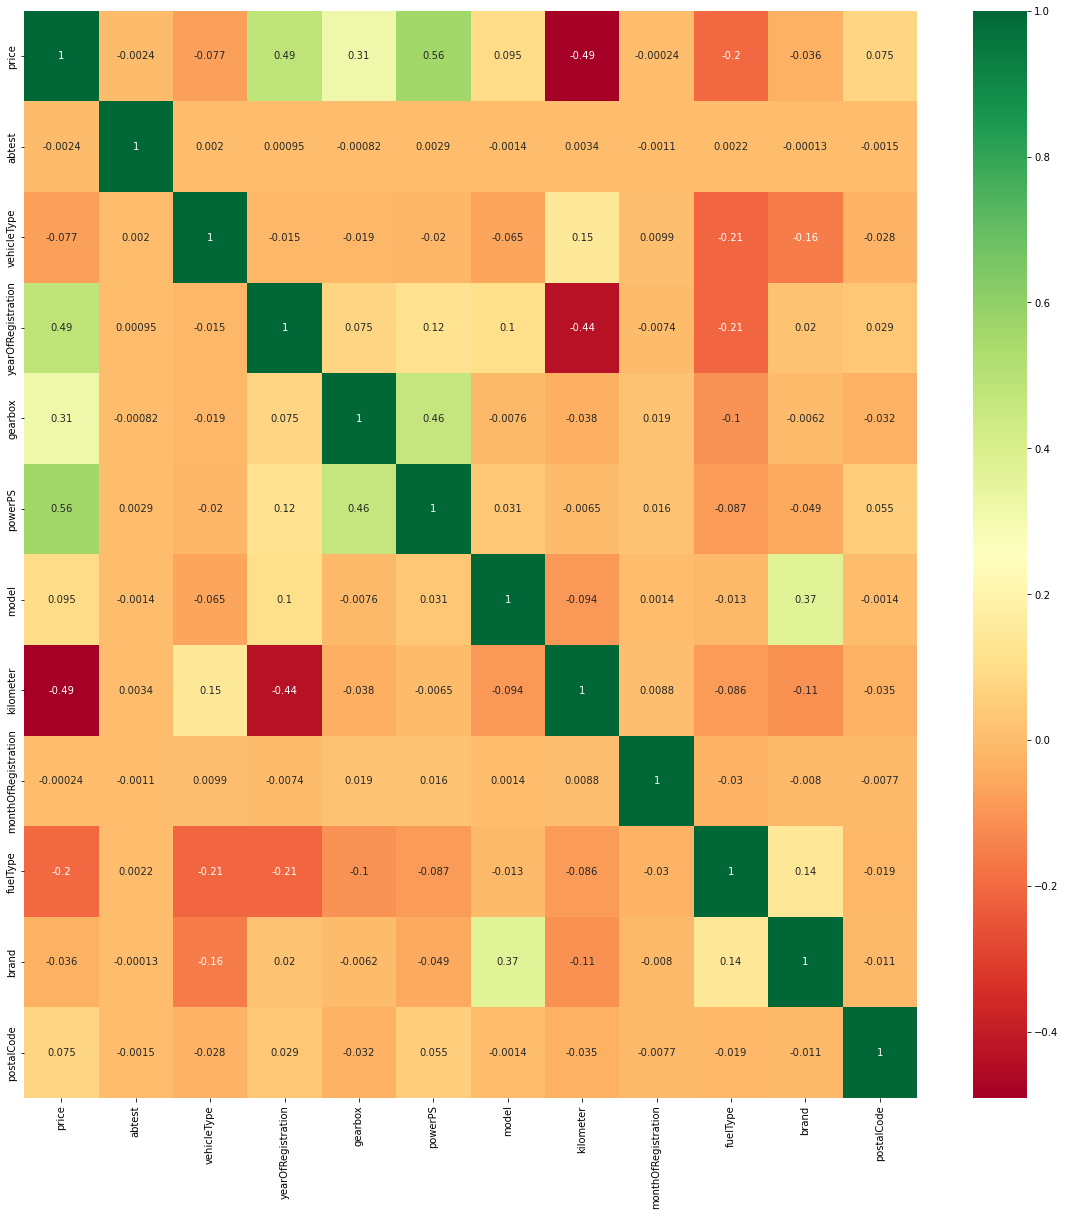

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
df.corr()
corrmat=df.corr() 
top_corr_features=corrmat.index 
plt.figure(figsize=(20,20))
g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

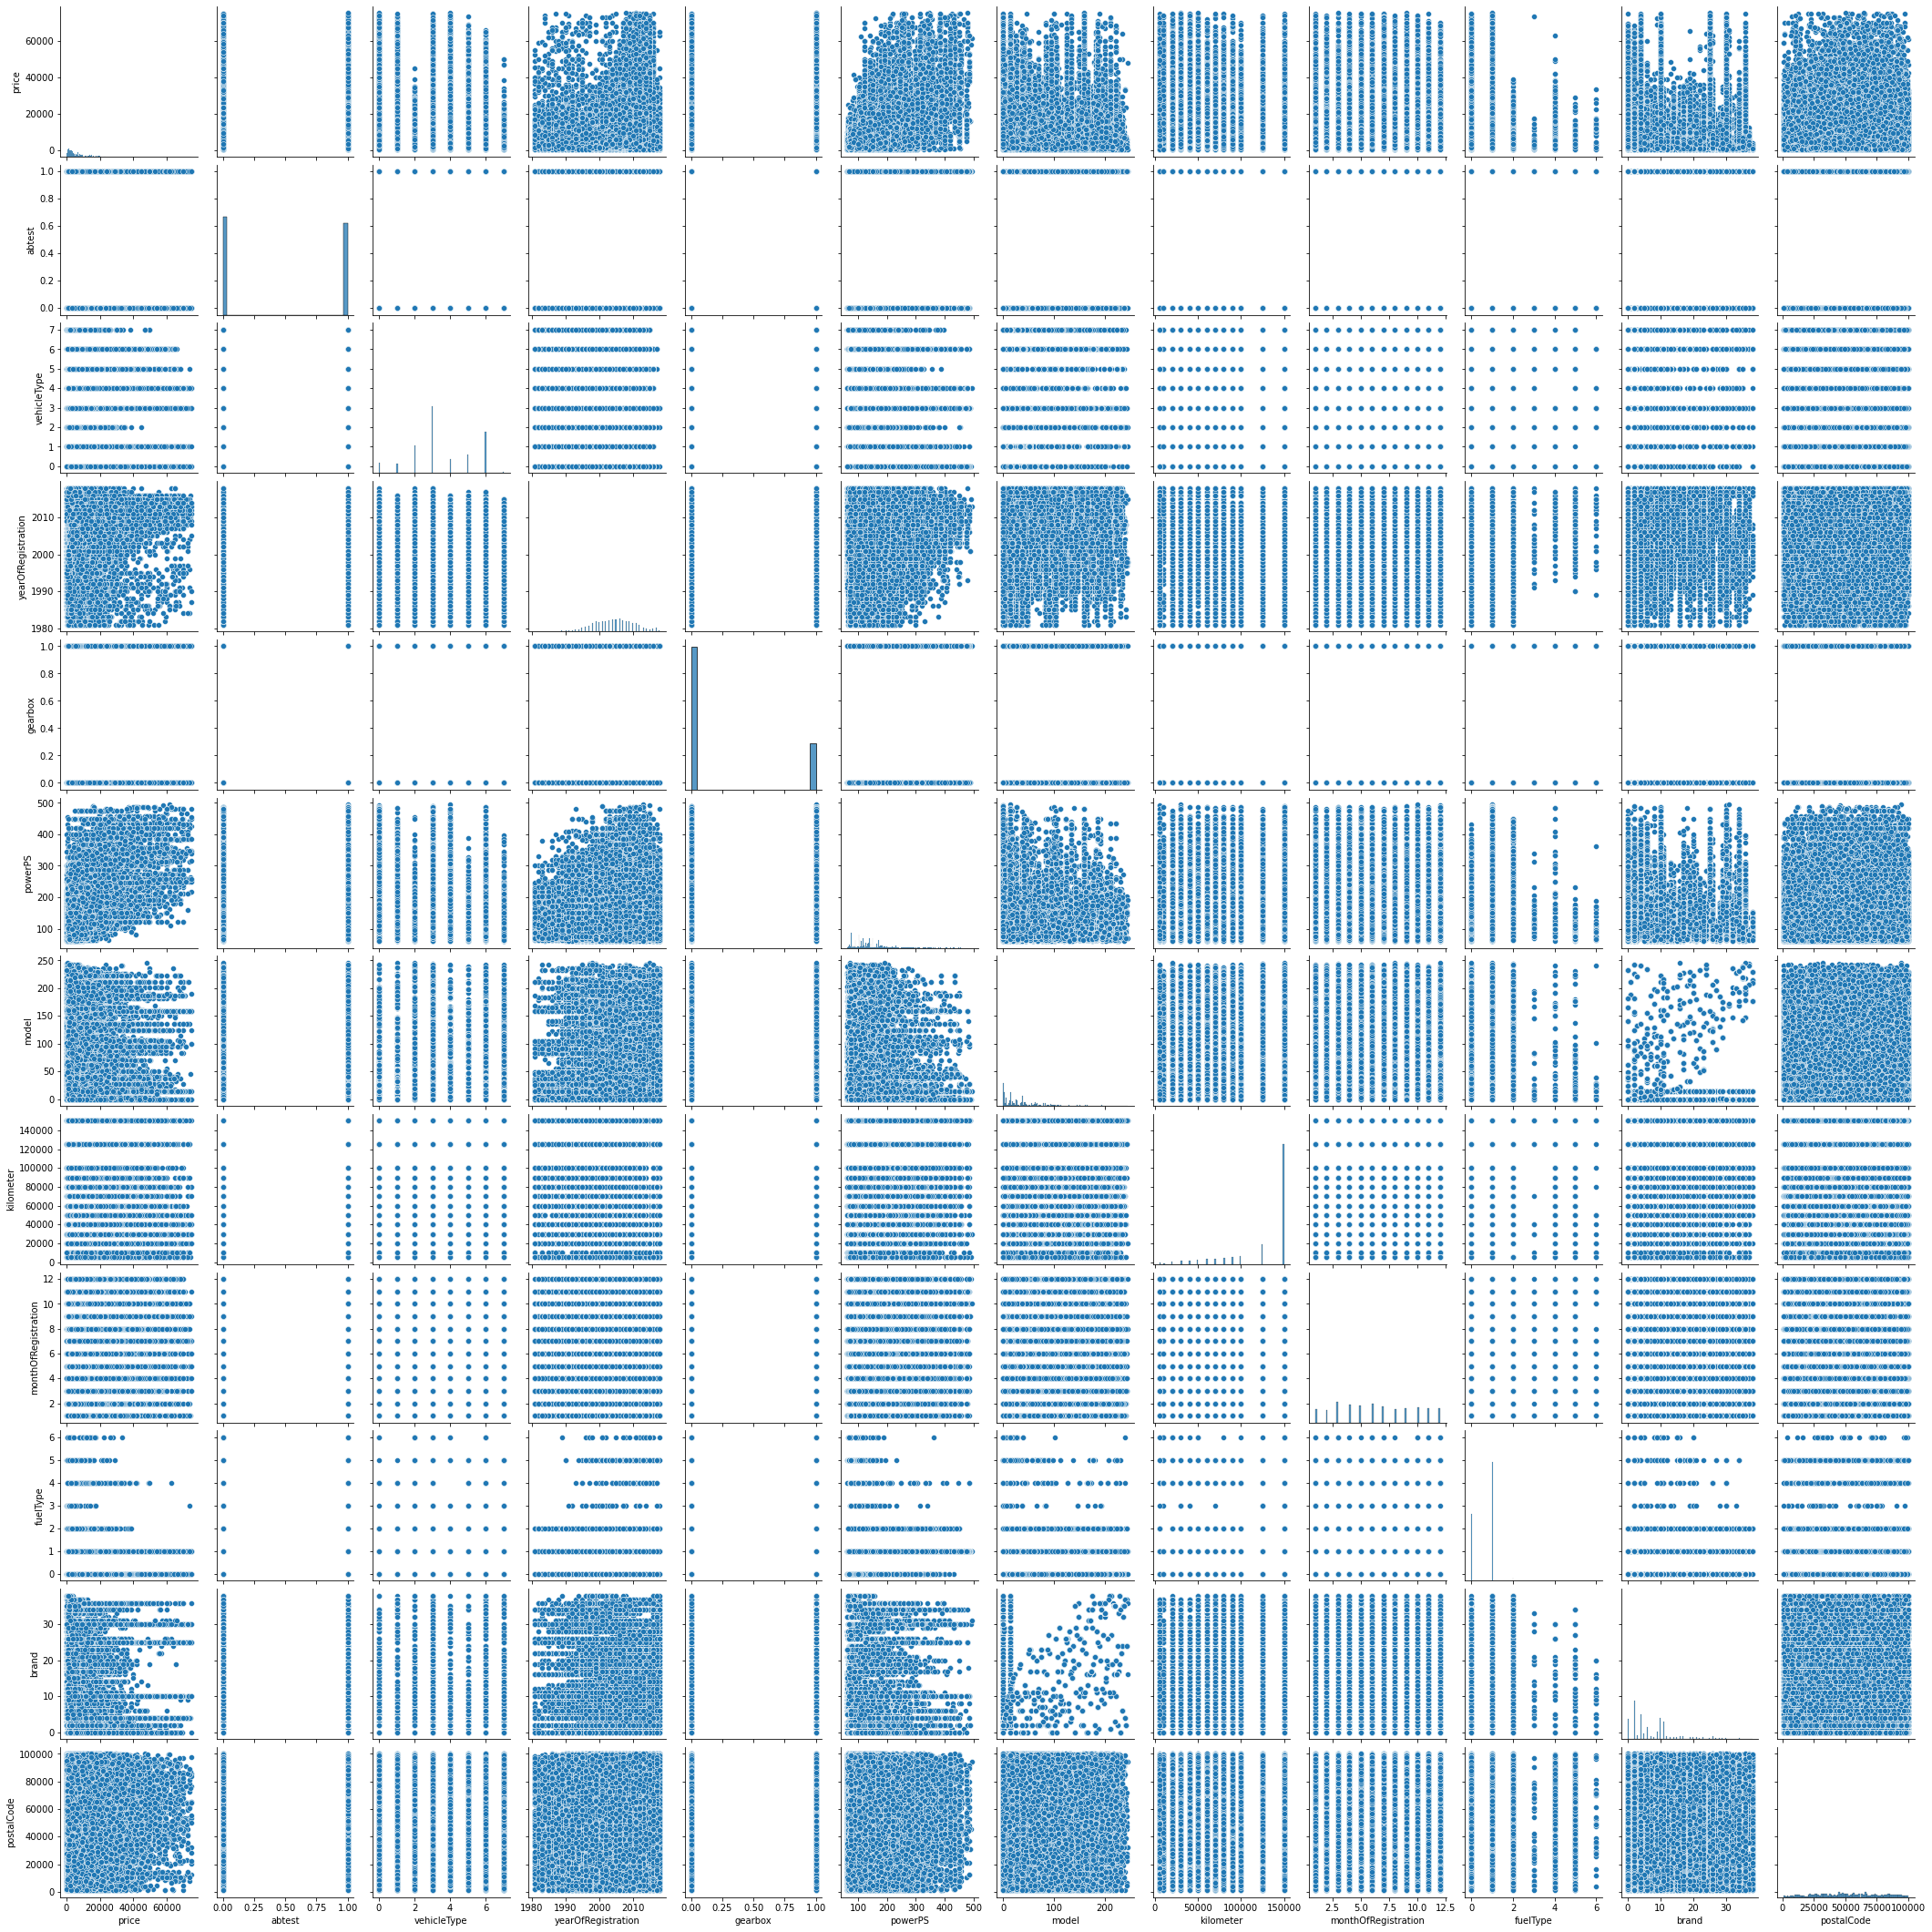

In [65]:
sns.pairplot(df)

<AxesSubplot:xlabel='model', ylabel='Count'>

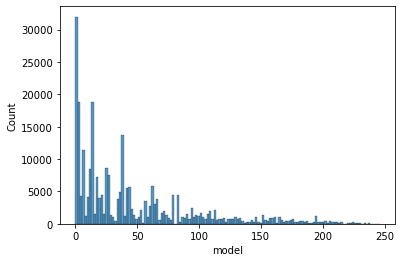

In [69]:
sns.histplot(data=df,x='model')


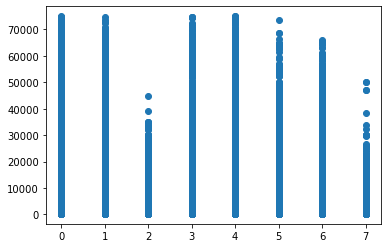

In [67]:
plt.scatter(df.vehicleType,df.price)


<AxesSubplot:xlabel='vehicleType', ylabel='Count'>

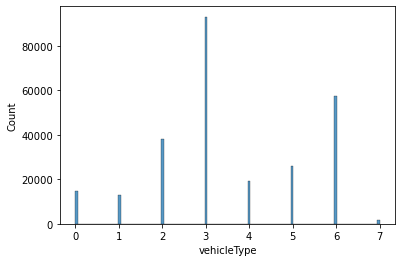

In [68]:
sns.histplot(data=df,x='vehicleType')


## IBM Deployment

In [61]:
!pip install -U ibm-watson-machine-learning

In [62]:
from ibm_watson_machine_learning import APIClient
import json

## Authenticate and Set Space

In [77]:
wml_credentials = {
    "apikey":"dgeeBORh2SzqgrVotLWCBMGh5LI9fTq5wml8_YmVnpBP",
    "url":"https://us-south.ml.cloud.ibm.com",
}

In [78]:
wml_client = APIClient(wml_credentials)
wml_client.spaces.list()

Note: 'limit' is not provided. Only first 50 records will be displayed if the number of records exceed 50
------------------------------------  ----------  ------------------------
ID                                    NAME        CREATED
05e2f8cd-6255-43d0-90b9-edf7f08f2d1d  Car resale  2022-11-15T17:38:26.934Z
------------------------------------  ----------  ------------------------


In [79]:
SPACE_ID='05e2f8cd-6255-43d0-90b9-edf7f08f2d1d'

In [80]:
wml_client.set.default_space(SPACE_ID)

'SUCCESS'

In [81]:
wml_client.software_specifications.list(500)

-------------------------------  ------------------------------------  ----
NAME                             ASSET_ID                              TYPE
default_py3.6                    0062b8c9-8b7d-44a0-a9b9-46c416adcbd9  base
kernel-spark3.2-scala2.12        020d69ce-7ac1-5e68-ac1a-31189867356a  base
pytorch-onnx_1.3-py3.7-edt       069ea134-3346-5748-b513-49120e15d288  base
scikit-learn_0.20-py3.6          09c5a1d0-9c1e-4473-a344-eb7b665ff687  base
spark-mllib_3.0-scala_2.12       09f4cff0-90a7-5899-b9ed-1ef348aebdee  base
pytorch-onnx_rt22.1-py3.9        0b848dd4-e681-5599-be41-b5f6fccc6471  base
ai-function_0.1-py3.6            0cdb0f1e-5376-4f4d-92dd-da3b69aa9bda  base
shiny-r3.6                       0e6e79df-875e-4f24-8ae9-62dcc2148306  base
tensorflow_2.4-py3.7-horovod     1092590a-307d-563d-9b62-4eb7d64b3f22  base
pytorch_1.1-py3.6                10ac12d6-6b30-4ccd-8392-3e922c096a92  base
tensorflow_1.15-py3.6-ddl        111e41b3-de2d-5422-a4d6-bf776828c4b7  base
autoai-kb_rt

## Save and Deploy the model

In [66]:
import sklearn
sklearn.__version__

'1.0.2'

In [82]:
MODEL_NAME='CarResale'
DEPLOYMENT_NAME='Car resale'
DEMO_MODEL=regressor

In [83]:
# Set Python Version
software_spec_uid = wml_client.software_specifications.get_id_by_name('runtime-22.1-py3.9')

In [84]:
# Setup model meta
model_props = {
    wml_client.repository.ModelMetaNames.NAME: MODEL_NAME, 
    wml_client.repository.ModelMetaNames.TYPE: 'scikit-learn_1.0', 
    wml_client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: software_spec_uid 
}

In [85]:
#Save model
model_details = wml_client.repository.store_model(
    model=DEMO_MODEL, 
    meta_props=model_props, 
    training_data=X_train, 
    training_target=Y_train
)

In [86]:
model_details

{'entity': {'hybrid_pipeline_software_specs': [],
  'label_column': 'price',
  'schemas': {'input': [{'fields': [{'name': 'abtest', 'type': 'int64'},
      {'name': 'vehicleType', 'type': 'int64'},
      {'name': 'yearOfRegistration', 'type': 'int64'},
      {'name': 'gearbox', 'type': 'int64'},
      {'name': 'powerPS', 'type': 'int64'},
      {'name': 'model', 'type': 'int64'},
      {'name': 'kilometer', 'type': 'int64'},
      {'name': 'monthOfRegistration', 'type': 'int64'},
      {'name': 'fuelType', 'type': 'int64'},
      {'name': 'brand', 'type': 'int64'},
      {'name': 'notRepairedDamage', 'type': 'int64'},
      {'name': 'postalCode', 'type': 'int64'}],
     'id': '1',
     'type': 'struct'}],
   'output': []},
  'software_spec': {'id': '12b83a17-24d8-5082-900f-0ab31fbfd3cb',
   'name': 'runtime-22.1-py3.9'},
  'type': 'scikit-learn_1.0'},
 'metadata': {'created_at': '2022-11-17T12:55:32.879Z',
  'id': 'c2d1a79b-d093-4b15-adea-4641c1f11b66',
  'modified_at': '2022-11-17T13:

In [87]:
model_id = wml_client.repository.get_model_id(model_details)
model_id

'c2d1a79b-d093-4b15-adea-4641c1f11b66'

In [88]:
# Set meta
deployment_props = {
    wml_client.deployments.ConfigurationMetaNames.NAME:DEPLOYMENT_NAME, 
    wml_client.deployments.ConfigurationMetaNames.ONLINE: {}
}

In [90]:
deployment = wml_client.deployments.create(
    artifact_uid=model_id, 
    meta_props=deployment_props 
)



#######################################################################################

Synchronous deployment creation for uid: 'c2d1a79b-d093-4b15-adea-4641c1f11b66' started

#######################################################################################


initializing
Note: online_url is deprecated and will be removed in a future release. Use serving_urls instead.
..
ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='76a8b70d-b0b3-4a06-a5e6-8507137d441b'
------------------------------------------------------------------------------------------------


